# Method 8 - Rest Ideas After 10

In [1]:
%matplotlib inline
import pandas as pd
import warnings
from statsmodels import api as sm

from eptooling import crsp, epd, fs, hfu, crsp, db, bi
from eptooling.bm import bmdb, iso
from epquant.engine import weights, portfolio
from epquant.gen import returns
from epquant.perf import relative_performance

warnings.filterwarnings("ignore")

## Fetch Holdings and Benchmark Data

In [2]:
# Get HFU Data

%store -r inst_data
inst_data = inst_data[inst_data['datadate'] >= '1999-06-30']

# Count number of positions per manager

inst_data['num_pos'] = inst_data.groupby(['datadate', 'institution_id'])[
    'fsym_id'].transform(lambda s: s.nunique())

# Remove less than 20 holdings and less than $5mm per CSP

valid_data = inst_data[inst_data['num_pos'] >= 20]
valid_data = valid_data[valid_data['public_aum'] >= 5e6]

# Use Raw Weight

valid_data['adj_target'] = valid_data['target']

## Calculate Rest Ideas

In [3]:
# Extract Rest Ideas

valid_data['pos_rank'] = valid_data\
    .groupby(['datadate', 'institution_id'])['adj_target'].rank(ascending=False)

best_ideas = valid_data[valid_data['pos_rank'] > 10].copy()

# Weight the best ideas

best_ideas['target'] = best_ideas['target'] / best_ideas.groupby([
    'datadate', 'institution_id'])['target'].transform('sum') * \
                        (1 / best_ideas.groupby('datadate')['institution_id']
                         .transform(lambda s: s.nunique()))

## Backtest Portfolio

In [4]:
w = weights.Weights(best_ideas)

%store -r r

p = portfolio.DailyPortfolio(w, r, end_date='2018-12-31')

rf = bi.get_risk_free_rate()
monthly_return = p.port_return.loc['1999-07-01':].resample('M').apply(epd.prod_red)
monthly_return = (monthly_return - rf).dropna()
monthly_return.name = 'port_return'

## Plot Performance

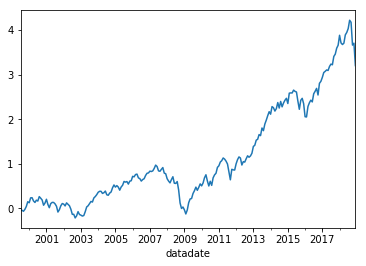

In [5]:
epd.nav(monthly_return).plot()

In [6]:
monthly_return.resample('A').apply(epd.prod_red)

datadate
1999-12-31    0.148786
2000-12-31   -0.025902
2001-12-31   -0.009611
2002-12-31   -0.221480
2003-12-31    0.515043
2004-12-31    0.166660
2005-12-31    0.061490
2006-12-31    0.108626
2007-12-31   -0.009870
2008-12-31   -0.420169
2009-12-31    0.503481
2010-12-31    0.238723
2011-12-31   -0.031030
2012-12-31    0.202131
2013-12-31    0.417246
2014-12-31    0.094853
2015-12-31   -0.034760
2016-12-31    0.149630
2017-12-31    0.210434
2018-12-31   -0.097961
Freq: A-DEC, Name: port_return, dtype: float64

## Fetch Factor Models

In [7]:
# Get Factor Models
q_factor_model = bi.get_q_factor_model()
fama_french_five_factor_model = bi.get_fama_french_five_factor_model()
four_factor_model = bi.get_four_factor_model()

# Concat Portfolio Return
q_factor = pd.concat([monthly_return, q_factor_model], axis=1)
fama_french_five = pd.concat([monthly_return, fama_french_five_factor_model], axis=1)
four_factor = pd.concat([monthly_return, four_factor_model], axis=1)

# Add Constants
q_factor.insert(1, 'const', 1)
fama_french_five.insert(1, 'const', 1)
four_factor.insert(1, 'const', 1)

# Split Period into Pre and Post Crisis
q_factor_pre, q_factor_post = q_factor.loc[:'2009-06-30'], q_factor.loc['2009-07-31':]
fama_french_five_pre, fama_french_five_post = fama_french_five.loc[:'2009-06-30'], fama_french_five.loc['2009-07-31':] 
four_factor_pre, four_factor_post = four_factor.loc[:'2009-06-30'], four_factor.loc['2009-07-31':] 

## Full Time Period Regressions

### Q Factor Model

In [8]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.977
Model:                            OLS   Adj. R-squared:                  0.976
Method:                 Least Squares   F-statistic:                     2419.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          5.24e-186
Time:                        06:25:15   Log-Likelihood:                 799.82
No. Observations:                 234   AIC:                            -1590.
Df Residuals:                     229   BIC:                            -1572.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0026      0.001      4.701      0.000       0.001       0.004
mktrf          1.0291      0.015     68.823      0.000       1.000       1.059
me             0.3203      0.017     18.418      0.000       0.286       0.355
ia             0.0878      0.026      3.321      0.001       0.036       0.140
roe           -0.1593      0.023     -7.038      0.000      -0.204      -0.115
==============================================================================
Omnibus:                       34.102   Durbin-Watson:                   1.841
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              232.353
Skew:                           0.175   Prob(JB):                     3.51e-51
Kurtosis:                       7.869   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [9]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.977
Model:                            OLS   Adj. R-squared:                  0.976
Method:                 Least Squares   F-statistic:                     1916.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          1.03e-174
Time:                        06:25:15   Log-Likelihood:                 799.82
No. Observations:                 234   AIC:                            -1590.
Df Residuals:                     229   BIC:                            -1572.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0026      0.001      3.910      0.000       0.001       0.004
mktrf          1.0291      0.018     58.563      0.000       0.995       1.064
me             0.3203      0.034      9.417      0.000       0.254       0.387
ia             0.0878      0.046      1.897      0.058      -0.003       0.178
roe           -0.1593      0.037     -4.277      0.000      -0.232      -0.086
==============================================================================
Omnibus:                       34.102   Durbin-Watson:                   1.841
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              232.353
Skew:                           0.175   Prob(JB):                     3.51e-51
Kurtosis:                       7.869   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [10]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.977
Model:                            OLS   Adj. R-squared:                  0.976
Method:                 Least Squares   F-statistic:                     2496.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          1.59e-187
Time:                        06:25:15   Log-Likelihood:                 799.82
No. Observations:                 234   AIC:                            -1590.
Df Residuals:                     229   BIC:                            -1572.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0026      0.001      3.748      0.000       0.001       0.004
mktrf          1.0291      0.018     58.246      0.000       0.994       1.064
me             0.3203      0.035      9.169      0.000       0.252       0.389
ia             0.0878      0.044      1.977      0.048       0.001       0.175
roe           -0.1593      0.041     -3.900      0.000      -0.239      -0.079
==============================================================================
Omnibus:                       34.102   Durbin-Watson:                   1.841
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              232.353
Skew:                           0.175   Prob(JB):                     3.51e-51
Kurtosis:                       7.869   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [11]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.971
Model:                            OLS   Adj. R-squared:                  0.971
Method:                 Least Squares   F-statistic:                     1539.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          1.92e-173
Time:                        06:25:15   Log-Likelihood:                 774.18
No. Observations:                 234   AIC:                            -1536.
Df Residuals:                     228   BIC:                            -1516.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0021      0.001      3.325      0.001       0.001       0.003
mktrf          1.0611      0.017     63.334      0.000       1.028       1.094
smb            0.3618      0.022     16.368      0.000       0.318       0.405
hml            0.0525      0.026      2.013      0.045       0.001       0.104
rmw           -0.0894      0.029     -3.033      0.003      -0.147      -0.031
cma            0.0480      0.037      1.283      0.201      -0.026       0.122
==============================================================================
Omnibus:                       54.416   Durbin-Watson:                   1.765
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              326.438
Skew:                           0.724   Prob(JB):                     1.30e-71
Kurtosis:                       8.602   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [12]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.971
Model:                            OLS   Adj. R-squared:                  0.971
Method:                 Least Squares   F-statistic:                     1273.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          2.30e-164
Time:                        06:25:15   Log-Likelihood:                 774.18
No. Observations:                 234   AIC:                            -1536.
Df Residuals:                     228   BIC:                            -1516.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0021      0.001      2.961      0.003       0.001       0.003
mktrf          1.0611      0.017     62.565      0.000       1.028       1.094
smb            0.3618      0.034     10.538      0.000       0.295       0.429
hml            0.0525      0.052      1.014      0.311      -0.049       0.154
rmw           -0.0894      0.038     -2.361      0.018      -0.164      -0.015
cma            0.0480      0.048      1.001      0.317      -0.046       0.142
==============================================================================
Omnibus:                       54.416   Durbin-Watson:                   1.765
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              326.438
Skew:                           0.724   Prob(JB):                     1.30e-71
Kurtosis:                       8.602   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [13]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.971
Model:                            OLS   Adj. R-squared:                  0.971
Method:                 Least Squares   F-statistic:                     1618.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          7.26e-176
Time:                        06:25:16   Log-Likelihood:                 774.18
No. Observations:                 234   AIC:                            -1536.
Df Residuals:                     228   BIC:                            -1516.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0021      0.001      2.709      0.007       0.001       0.004
mktrf          1.0611      0.016     64.629      0.000       1.029       1.093
smb            0.3618      0.033     10.844      0.000       0.296       0.427
hml            0.0525      0.050      1.040      0.298      -0.046       0.151
rmw           -0.0894      0.042     -2.103      0.035      -0.173      -0.006
cma            0.0480      0.045      1.076      0.282      -0.039       0.136
==============================================================================
Omnibus:                       54.416   Durbin-Watson:                   1.765
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              326.438
Skew:                           0.724   Prob(JB):                     1.30e-71
Kurtosis:                       8.602   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [14]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.972
Model:                            OLS   Adj. R-squared:                  0.972
Method:                 Least Squares   F-statistic:                     2022.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          2.62e-177
Time:                        06:25:16   Log-Likelihood:                 779.34
No. Observations:                 234   AIC:                            -1549.
Df Residuals:                     229   BIC:                            -1531.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0023      0.001      3.921      0.000       0.001       0.003
mktrf          1.0391      0.015     69.155      0.000       1.009       1.069
smb            0.3994      0.019     21.293      0.000       0.362       0.436
hml            0.0969      0.019      5.198      0.000       0.060       0.134
umd           -0.0831      0.012     -6.802      0.000      -0.107      -0.059
==============================================================================
Omnibus:                       25.450   Durbin-Watson:                   1.826
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              107.876
Skew:                           0.213   Prob(JB):                     3.76e-24
Kurtosis:                       6.299   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [15]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.972
Model:                            OLS   Adj. R-squared:                  0.972
Method:                 Least Squares   F-statistic:                     1746.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          3.09e-170
Time:                        06:25:16   Log-Likelihood:                 779.34
No. Observations:                 234   AIC:                            -1549.
Df Residuals:                     229   BIC:                            -1531.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0023      0.001      3.033      0.002       0.001       0.004
mktrf          1.0391      0.019     55.676      0.000       1.003       1.076
smb            0.3994      0.025     15.973      0.000       0.350       0.448
hml            0.0969      0.048      2.006      0.045       0.002       0.191
umd           -0.0831      0.023     -3.657      0.000      -0.128      -0.039
==============================================================================
Omnibus:                       25.450   Durbin-Watson:                   1.826
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              107.876
Skew:                           0.213   Prob(JB):                     3.76e-24
Kurtosis:                       6.299   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [16]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.972
Model:                            OLS   Adj. R-squared:                  0.972
Method:                 Least Squares   F-statistic:                     2131.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          7.46e-180
Time:                        06:25:16   Log-Likelihood:                 779.34
No. Observations:                 234   AIC:                            -1549.
Df Residuals:                     229   BIC:                            -1531.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0023      0.001      2.818      0.005       0.001       0.004
mktrf          1.0391      0.016     66.922      0.000       1.009       1.070
smb            0.3994      0.026     15.145      0.000       0.348       0.451
hml            0.0969      0.053      1.835      0.067      -0.007       0.200
umd           -0.0831      0.019     -4.455      0.000      -0.120      -0.047
==============================================================================
Omnibus:                       25.450   Durbin-Watson:                   1.826
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              107.876
Skew:                           0.213   Prob(JB):                     3.76e-24
Kurtosis:                       6.299   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Pre-Crisis Regressions

### Q Factor Model

In [17]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.973
Model:                            OLS   Adj. R-squared:                  0.972
Method:                 Least Squares   F-statistic:                     1050.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.72e-89
Time:                        06:25:16   Log-Likelihood:                 388.27
No. Observations:                 120   AIC:                            -766.5
Df Residuals:                     115   BIC:                            -752.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0038      0.001      4.047      0.000       0.002       0.006
mktrf          1.0260      0.025     40.940      0.000       0.976       1.076
me             0.2855      0.025     11.536      0.000       0.237       0.335
ia             0.1304      0.039      3.364      0.001       0.054       0.207
roe           -0.1822      0.034     -5.311      0.000      -0.250      -0.114
==============================================================================
Omnibus:                       11.176   Durbin-Watson:                   1.870
Prob(Omnibus):                  0.004   Jarque-Bera (JB):               29.991
Skew:                           0.061   Prob(JB):                     3.07e-07
Kurtosis:                       5.446   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [18]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.973
Model:                            OLS   Adj. R-squared:                  0.972
Method:                 Least Squares   F-statistic:                     1417.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           8.35e-97
Time:                        06:25:16   Log-Likelihood:                 388.27
No. Observations:                 120   AIC:                            -766.5
Df Residuals:                     115   BIC:                            -752.6
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0038      0.001      3.269      0.001       0.002       0.006
mktrf          1.0260      0.025     40.469      0.000       0.976       1.076
me             0.2855      0.036      7.948      0.000       0.215       0.356
ia             0.1304      0.052      2.512      0.012       0.029       0.232
roe           -0.1822      0.045     -4.070      0.000      -0.270      -0.094
==============================================================================
Omnibus:                       11.176   Durbin-Watson:                   1.870
Prob(Omnibus):                  0.004   Jarque-Bera (JB):               29.991
Skew:                           0.061   Prob(JB):                     3.07e-07
Kurtosis:                       5.446   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [19]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.973
Model:                            OLS   Adj. R-squared:                  0.972
Method:                 Least Squares   F-statistic:                     2690.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          1.45e-112
Time:                        06:25:16   Log-Likelihood:                 388.27
No. Observations:                 120   AIC:                            -766.5
Df Residuals:                     115   BIC:                            -752.6
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0038      0.001      3.017      0.003       0.001       0.006
mktrf          1.0260      0.023     43.689      0.000       0.980       1.072
me             0.2855      0.038      7.535      0.000       0.211       0.360
ia             0.1304      0.043      3.046      0.002       0.046       0.214
roe           -0.1822      0.048     -3.822      0.000      -0.276      -0.089
==============================================================================
Omnibus:                       11.176   Durbin-Watson:                   1.870
Prob(Omnibus):                  0.004   Jarque-Bera (JB):               29.991
Skew:                           0.061   Prob(JB):                     3.07e-07
Kurtosis:                       5.446   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [20]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.966
Model:                            OLS   Adj. R-squared:                  0.964
Method:                 Least Squares   F-statistic:                     647.5
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           6.40e-82
Time:                        06:25:16   Log-Likelihood:                 373.64
No. Observations:                 120   AIC:                            -735.3
Df Residuals:                     114   BIC:                            -718.6
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0038      0.001      3.467      0.001       0.002       0.006
mktrf          1.1017      0.030     36.741      0.000       1.042       1.161
smb            0.3464      0.034     10.201      0.000       0.279       0.414
hml            0.0388      0.042      0.931      0.354      -0.044       0.121
rmw           -0.0689      0.049     -1.403      0.163      -0.166       0.028
cma            0.1071      0.054      1.993      0.049       0.001       0.214
==============================================================================
Omnibus:                       20.656   Durbin-Watson:                   1.899
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               67.382
Skew:                           0.493   Prob(JB):                     2.33e-15
Kurtosis:                       6.536   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [21]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.966
Model:                            OLS   Adj. R-squared:                  0.964
Method:                 Least Squares   F-statistic:                     839.5
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           3.76e-88
Time:                        06:25:16   Log-Likelihood:                 373.64
No. Observations:                 120   AIC:                            -735.3
Df Residuals:                     114   BIC:                            -718.6
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0038      0.001      3.058      0.002       0.001       0.006
mktrf          1.1017      0.033     33.720      0.000       1.038       1.166
smb            0.3464      0.049      7.092      0.000       0.251       0.442
hml            0.0388      0.085      0.457      0.647      -0.127       0.205
rmw           -0.0689      0.067     -1.021      0.307      -0.201       0.063
cma            0.1071      0.055      1.942      0.052      -0.001       0.215
==============================================================================
Omnibus:                       20.656   Durbin-Watson:                   1.899
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               67.382
Skew:                           0.493   Prob(JB):                     2.33e-15
Kurtosis:                       6.536   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [22]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.966
Model:                            OLS   Adj. R-squared:                  0.964
Method:                 Least Squares   F-statistic:                     1401.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          1.47e-100
Time:                        06:25:16   Log-Likelihood:                 373.64
No. Observations:                 120   AIC:                            -735.3
Df Residuals:                     114   BIC:                            -718.6
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0038      0.001      2.837      0.005       0.001       0.006
mktrf          1.1017      0.031     35.069      0.000       1.040       1.163
smb            0.3464      0.048      7.188      0.000       0.252       0.441
hml            0.0388      0.085      0.458      0.647      -0.127       0.205
rmw           -0.0689      0.073     -0.937      0.349      -0.213       0.075
cma            0.1071      0.051      2.119      0.034       0.008       0.206
==============================================================================
Omnibus:                       20.656   Durbin-Watson:                   1.899
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               67.382
Skew:                           0.493   Prob(JB):                     2.33e-15
Kurtosis:                       6.536   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [23]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.968
Model:                            OLS   Adj. R-squared:                  0.967
Method:                 Least Squares   F-statistic:                     867.9
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           7.05e-85
Time:                        06:25:16   Log-Likelihood:                 377.18
No. Observations:                 120   AIC:                            -744.4
Df Residuals:                     115   BIC:                            -730.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0040      0.001      3.975      0.000       0.002       0.006
mktrf          1.0499      0.024     43.358      0.000       1.002       1.098
smb            0.3939      0.028     14.288      0.000       0.339       0.449
hml            0.1178      0.028      4.266      0.000       0.063       0.173
umd           -0.0873      0.017     -5.130      0.000      -0.121      -0.054
==============================================================================
Omnibus:                        8.788   Durbin-Watson:                   1.938
Prob(Omnibus):                  0.012   Jarque-Bera (JB):               19.054
Skew:                           0.032   Prob(JB):                     7.29e-05
Kurtosis:                       4.951   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [24]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.968
Model:                            OLS   Adj. R-squared:                  0.967
Method:                 Least Squares   F-statistic:                     1105.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           9.71e-91
Time:                        06:25:16   Log-Likelihood:                 377.18
No. Observations:                 120   AIC:                            -744.4
Df Residuals:                     115   BIC:                            -730.4
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0040      0.001      3.608      0.000       0.002       0.006
mktrf          1.0499      0.030     35.549      0.000       0.992       1.108
smb            0.3939      0.031     12.904      0.000       0.334       0.454
hml            0.1178      0.062      1.895      0.058      -0.004       0.240
umd           -0.0873      0.026     -3.301      0.001      -0.139      -0.035
==============================================================================
Omnibus:                        8.788   Durbin-Watson:                   1.938
Prob(Omnibus):                  0.012   Jarque-Bera (JB):               19.054
Skew:                           0.032   Prob(JB):                     7.29e-05
Kurtosis:                       4.951   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [25]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.968
Model:                            OLS   Adj. R-squared:                  0.967
Method:                 Least Squares   F-statistic:                     1467.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.21e-97
Time:                        06:25:16   Log-Likelihood:                 377.18
No. Observations:                 120   AIC:                            -744.4
Df Residuals:                     115   BIC:                            -730.4
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0040      0.001      3.428      0.001       0.002       0.006
mktrf          1.0499      0.023     45.640      0.000       1.005       1.095
smb            0.3939      0.033     11.906      0.000       0.329       0.459
hml            0.1178      0.066      1.774      0.076      -0.012       0.248
umd           -0.0873      0.021     -4.113      0.000      -0.129      -0.046
==============================================================================
Omnibus:                        8.788   Durbin-Watson:                   1.938
Prob(Omnibus):                  0.012   Jarque-Bera (JB):               19.054
Skew:                           0.032   Prob(JB):                     7.29e-05
Kurtosis:                       4.951   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Post-Crisis Regressions

### Q Factor Model

In [26]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.989
Model:                            OLS   Adj. R-squared:                  0.988
Method:                 Least Squares   F-statistic:                     2390.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          3.73e-105
Time:                        06:25:16   Log-Likelihood:                 449.00
No. Observations:                 114   AIC:                            -888.0
Df Residuals:                     109   BIC:                            -874.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0016      0.000      3.292      0.001       0.001       0.003
mktrf          1.0252      0.014     72.359      0.000       0.997       1.053
me             0.4010      0.022     18.330      0.000       0.358       0.444
ia            -0.0449      0.030     -1.481      0.142      -0.105       0.015
roe           -0.1582      0.027     -5.935      0.000      -0.211      -0.105
==============================================================================
Omnibus:                        9.311   Durbin-Watson:                   2.110
Prob(Omnibus):                  0.010   Jarque-Bera (JB):                9.651
Skew:                          -0.711   Prob(JB):                      0.00802
Kurtosis:                       3.103   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [27]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.989
Model:                            OLS   Adj. R-squared:                  0.988
Method:                 Least Squares   F-statistic:                     2369.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          6.13e-105
Time:                        06:25:16   Log-Likelihood:                 449.00
No. Observations:                 114   AIC:                            -888.0
Df Residuals:                     109   BIC:                            -874.3
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0016      0.000      4.026      0.000       0.001       0.002
mktrf          1.0252      0.013     78.977      0.000       1.000       1.051
me             0.4010      0.018     22.835      0.000       0.367       0.435
ia            -0.0449      0.029     -1.533      0.125      -0.102       0.013
roe           -0.1582      0.023     -6.860      0.000      -0.203      -0.113
==============================================================================
Omnibus:                        9.311   Durbin-Watson:                   2.110
Prob(Omnibus):                  0.010   Jarque-Bera (JB):                9.651
Skew:                          -0.711   Prob(JB):                      0.00802
Kurtosis:                       3.103   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [28]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.989
Model:                            OLS   Adj. R-squared:                  0.988
Method:                 Least Squares   F-statistic:                     2489.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          4.20e-106
Time:                        06:25:16   Log-Likelihood:                 449.00
No. Observations:                 114   AIC:                            -888.0
Df Residuals:                     109   BIC:                            -874.3
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0016      0.000      4.093      0.000       0.001       0.002
mktrf          1.0252      0.013     80.906      0.000       1.000       1.050
me             0.4010      0.017     23.652      0.000       0.368       0.434
ia            -0.0449      0.031     -1.428      0.153      -0.107       0.017
roe           -0.1582      0.023     -7.022      0.000      -0.202      -0.114
==============================================================================
Omnibus:                        9.311   Durbin-Watson:                   2.110
Prob(Omnibus):                  0.010   Jarque-Bera (JB):                9.651
Skew:                          -0.711   Prob(JB):                      0.00802
Kurtosis:                       3.103   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [29]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.989
Model:                            OLS   Adj. R-squared:                  0.989
Method:                 Least Squares   F-statistic:                     2010.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          8.31e-105
Time:                        06:25:16   Log-Likelihood:                 452.33
No. Observations:                 114   AIC:                            -892.7
Df Residuals:                     108   BIC:                            -876.2
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0006      0.000      1.289      0.200      -0.000       0.002
mktrf          1.0358      0.013     78.562      0.000       1.010       1.062
smb            0.3778      0.021     17.650      0.000       0.335       0.420
hml            0.0184      0.027      0.673      0.502      -0.036       0.072
rmw           -0.2067      0.033     -6.184      0.000      -0.273      -0.140
cma           -0.0639      0.042     -1.507      0.135      -0.148       0.020
==============================================================================
Omnibus:                        6.017   Durbin-Watson:                   1.980
Prob(Omnibus):                  0.049   Jarque-Bera (JB):                5.595
Skew:                          -0.530   Prob(JB):                       0.0610
Kurtosis:                       3.231   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [30]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.989
Model:                            OLS   Adj. R-squared:                  0.989
Method:                 Least Squares   F-statistic:                     1642.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          4.07e-100
Time:                        06:25:16   Log-Likelihood:                 452.33
No. Observations:                 114   AIC:                            -892.7
Df Residuals:                     108   BIC:                            -876.2
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0006      0.000      1.447      0.148      -0.000       0.001
mktrf          1.0358      0.013     77.886      0.000       1.010       1.062
smb            0.3778      0.019     20.168      0.000       0.341       0.414
hml            0.0184      0.026      0.694      0.488      -0.034       0.070
rmw           -0.2067      0.032     -6.465      0.000      -0.269      -0.144
cma           -0.0639      0.044     -1.448      0.147      -0.150       0.023
==============================================================================
Omnibus:                        6.017   Durbin-Watson:                   1.980
Prob(Omnibus):                  0.049   Jarque-Bera (JB):                5.595
Skew:                          -0.530   Prob(JB):                       0.0610
Kurtosis:                       3.231   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [31]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.989
Model:                            OLS   Adj. R-squared:                  0.989
Method:                 Least Squares   F-statistic:                     2512.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          5.49e-110
Time:                        06:25:16   Log-Likelihood:                 452.33
No. Observations:                 114   AIC:                            -892.7
Df Residuals:                     108   BIC:                            -876.2
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0006      0.000      1.309      0.191      -0.000       0.002
mktrf          1.0358      0.011     90.420      0.000       1.013       1.058
smb            0.3778      0.018     21.151      0.000       0.343       0.413
hml            0.0184      0.028      0.652      0.514      -0.037       0.074
rmw           -0.2067      0.031     -6.639      0.000      -0.268      -0.146
cma           -0.0639      0.049     -1.306      0.192      -0.160       0.032
==============================================================================
Omnibus:                        6.017   Durbin-Watson:                   1.980
Prob(Omnibus):                  0.049   Jarque-Bera (JB):                5.595
Skew:                          -0.530   Prob(JB):                       0.0610
Kurtosis:                       3.231   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [32]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.986
Model:                            OLS   Adj. R-squared:                  0.986
Method:                 Least Squares   F-statistic:                     1937.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          3.10e-100
Time:                        06:25:16   Log-Likelihood:                 437.15
No. Observations:                 114   AIC:                            -864.3
Df Residuals:                     109   BIC:                            -850.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003      0.001      0.594      0.553      -0.001       0.001
mktrf          1.0461      0.015     70.222      0.000       1.017       1.076
smb            0.4274      0.023     18.401      0.000       0.381       0.473
hml            0.0217      0.024      0.906      0.367      -0.026       0.069
umd           -0.0641      0.018     -3.550      0.001      -0.100      -0.028
==============================================================================
Omnibus:                        6.505   Durbin-Watson:                   1.769
Prob(Omnibus):                  0.039   Jarque-Bera (JB):                5.998
Skew:                          -0.493   Prob(JB):                       0.0498
Kurtosis:                       3.537   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [33]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.986
Model:                            OLS   Adj. R-squared:                  0.986
Method:                 Least Squares   F-statistic:                     1552.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           4.52e-95
Time:                        06:25:16   Log-Likelihood:                 437.15
No. Observations:                 114   AIC:                            -864.3
Df Residuals:                     109   BIC:                            -850.6
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003      0.001      0.623      0.534      -0.001       0.001
mktrf          1.0461      0.016     64.784      0.000       1.014       1.078
smb            0.4274      0.021     20.128      0.000       0.386       0.469
hml            0.0217      0.027      0.801      0.423      -0.031       0.075
umd           -0.0641      0.017     -3.782      0.000      -0.097      -0.031
==============================================================================
Omnibus:                        6.505   Durbin-Watson:                   1.769
Prob(Omnibus):                  0.039   Jarque-Bera (JB):                5.998
Skew:                          -0.493   Prob(JB):                       0.0498
Kurtosis:                       3.537   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [34]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.986
Model:                            OLS   Adj. R-squared:                  0.986
Method:                 Least Squares   F-statistic:                     3049.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          7.46e-111
Time:                        06:25:16   Log-Likelihood:                 437.15
No. Observations:                 114   AIC:                            -864.3
Df Residuals:                     109   BIC:                            -850.6
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003      0.001      0.612      0.540      -0.001       0.001
mktrf          1.0461      0.015     71.274      0.000       1.017       1.075
smb            0.4274      0.016     26.881      0.000       0.396       0.459
hml            0.0217      0.025      0.872      0.383      -0.027       0.070
umd           -0.0641      0.016     -3.948      0.000      -0.096      -0.032
==============================================================================
Omnibus:                        6.505   Durbin-Watson:                   1.769
Prob(Omnibus):                  0.039   Jarque-Bera (JB):                5.998
Skew:                          -0.493   Prob(JB):                       0.0498
Kurtosis:                       3.537   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""